Plot the positions of the CTD casts on a map, along with the front position.

In [1]:
import alborexdata
import os
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap 
import numpy as np
import datetime
import alborexpaths
from alborexpaths import coordinates1, coordinates2
from importlib import reload

/home/ctroupin/Software/PythonEnvs/Diva-python3.6/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

# Configuration

In [3]:
with open('alborexconfig.json') as json_data_file:
    config = json.load(json_data_file)

In [4]:
logger = alborexdata.configure_logging("./logs/alborexFigure5.log")

Domain

In [5]:
coordinates = config["domain"]["coordinates1"]
coordinates2 = config["domain"]["coordinates2"]
dlon, dlat = config["domain"]["coordinates1"][0], config["domain"]["coordinates1"][1]

Directories

In [6]:
figdir = config["figdir"]

In [7]:
coastfile = config["datafiles"]["coast"]
rvfile = config["datafiles"]["rv"]
ctdfile = config["datafiles"]["ctd"]

# Data reading and plotting

Make figure directory if necessary.

In [8]:
if os.path.isdir(figdir):
    logger.debug("Figure directory {0} already exists".format(figdir))
else:
    os.makedirs(figdir)
    logger.debug("Creating figure directory {0}".format(figdir))

2019-01-10 20:52:07,246 - alborex_logger - DEBUG - Figure directory ../figures already exists


## Coastline

In [9]:
loncoast, latcoast = alborexdata.read_lonlat_coast(coastfile)

## Ship track

In [10]:
ship = alborexdata.Ship()
ship.get_from_netcdf(rvfile)
ship.apply_qc_latlon(QC=[1, 2])

## SST

In [11]:
coastfile = config["datafiles"]["coast"]
sstfilelist = config["datafiles"]["sst"]
sstfilelistremote = config["datafiles"]["sstremote"]
for sstfile, sstremote in zip(sstfilelist, sstfilelistremote):
    if not(os.path.exists(sstfile)):
        logger.info("Downloading data file {}".format(os.path.basename(sstfile)))
        urllib.request.urlretrieve(sstremote, sstfile)
    else:
        logger.info("SST file {} already downloaded".format(os.path.basename(sstfile)))
sst = alborexdata.SST()
sst.read_from_oceancolorL2(sstfilelist[1])
sst.apply_qc()

2019-01-10 20:52:07,851 - alborex_logger - INFO - SST file A2014145125000.L2_LAC_SST.nc already downloaded
2019-01-10 20:52:07,853 - alborex_logger - INFO - SST file A2014150020500.L2_LAC_SST.nc already downloaded


## Front position

In [12]:
# Add front position
datafile = config["datafiles"]["front"]
f = alborexdata.Front()
f.get_from_file(datafile)
f.smooth()

Create the projection

In [13]:
m = Basemap(projection='merc', llcrnrlon=coordinates2[0], llcrnrlat=coordinates2[2],
            urcrnrlon=coordinates2[1], urcrnrlat=coordinates2[3],
            lat_ts=0.5 * (coordinates2[2] + coordinates2[3]), resolution='i')

## Plot CTD positions

2019-01-10 20:52:09,984 - alborex_logger - INFO - Making figure fig03
/home/ctroupin/Software/PythonEnvs/Diva-python3.6/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4771: RuntimeWarning: invalid value encountered in greater
  lonsin = np.where(lonsin > lon_0+180, lonsin-360 ,lonsin)
/home/ctroupin/Software/PythonEnvs/Diva-python3.6/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4772: RuntimeWarning: invalid value encountered in less
  lonsin = np.where(lonsin < lon_0-180, lonsin+360 ,lonsin)
/home/ctroupin/Software/PythonEnvs/Diva-python3.6/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4776: RuntimeWarning: invalid value encountered in greater_equal
  itemindex = len(lonsin)-np.where(londiff>=thresh)[0]
2019-01-10 20:52:14,170 - alborex_logger - INFO - Figure saved as ../figures/fig03


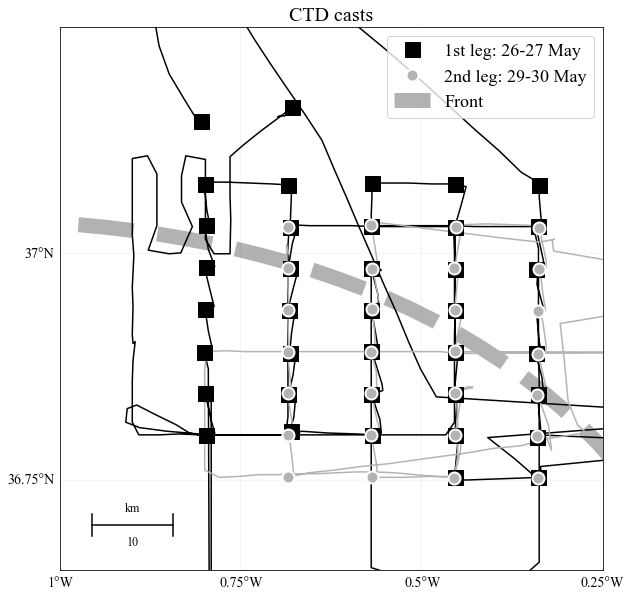

In [14]:
figname = "fig03"
figtitle = "CTD casts"
logger.info("Making figure {0}".format(figname))

fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111)
m.ax = ax

# Add the coastline
for i in range(0, len(loncoast)):
    m.plot(np.array(loncoast[i]), np.array(latcoast[i]), 
           color='k', linewidth=.25, latlon=True)

alborexdata.add_map_grid(m, coordinates, dlon=.25, dlat=.25,
                         fontname='Times New Roman', fontsize=14, 
                         linewidth=0.2, zorder=1, color=".6")
    
# Read data from file
ctd = alborexdata.CTD()
ctd.get_from_netcdf(ctdfile)

# Add to plot
m.plot(ctd.lon[:38], ctd.lat[:38], 's', ms=15, color="k",
       latlon=True, label="1st leg: 26-27 May", zorder=4)
m.plot(ctd.lon[38:], ctd.lat[38:], 'o', color=".7", ms=12, 
       markeredgecolor="w", markeredgewidth=2,
       latlon=True, label="2nd leg: 29-30 May", zorder=5)

# Add ship track
ship.lon.mask = False
ship.lat.mask = False
ship.select_dates(finaldate=ctd.dates[38])
ship.plot_track(m, color="k", zorder=3)

# Reset mask
ship.lon.mask = False
ship.lat.mask = False
ship.select_dates(finaldate=ctd.dates[-1], initialdate=ctd.dates[39])
ship.plot_track(m, color=".7", zorder=3, linestyle="-")

# Plot front
m.plot(f.lon, f.lat, "--", color=".4", linewidth=15, latlon=True, alpha=.5, label="Front")

# Map scale
m.drawmapscale(-0.9, 36.7, -0.9, 36.7, 10, barstyle='simple', 
               units='km', fontsize=12, zorder=3)

# Legend
plt.legend(loc=1, fontsize=18, framealpha=.8)
plt.title(figtitle, fontsize=20)

plt.savefig(os.path.join(figdir, figname), dpi=300, bbox_inches='tight')
logger.info("Figure saved as {}".format(os.path.join(figdir, figname)))
plt.show()
plt.close()